# This notebook provides the solution for Question 3


In this approach im:
*   Adding dialgoue context to the character document
*   Performing Grid search for this approach to find the best parameters that work for Context.
* Evaluating the best configurations on the validation data
* Testing the best configurations on the testing data




## Import Libraries

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
import re
import math
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from sklearn.feature_extraction import DictVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import csr_matrix

%matplotlib inline
pd.options.display.max_colwidth=500

## Load Data

In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)

val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)

test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

In [ ]:
# Inspect
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
14008,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
14009,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
14010,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
14011,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


## Helper Functions

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

## Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

### Add `Context` column to the datasets

In [ ]:
def add_context_to_dataframe(df):
    """
    Add a 'Context' column to the dataframe by grouping lines within the same Episode and Scene.

    Args: takes the dataset as input

    Returns:
        The updated DataFrame with a new 'Context' column.
    """
    # Drop rows with missing values
    df = df.dropna(subset=["Episode", "Scene", "Line", "Character_name"]).reset_index(drop=True)

    df["Context"] = pd.Series(dtype="object")  # Initialize Context column
    grouped = df.groupby(['Episode', 'Scene'])  # Group by Episode and Scene

    contexts = []

    for _, group in grouped:
        group = group.reset_index(drop=True)
        for idx, row in group.iterrows():
            # Handle single-row group
            if len(group) == 1:
                context = {"PRE": "None", "CURRENT": row["Line"], "POST": "None"}
            # Handle first row
            elif idx == 0:
                post = group.iloc[idx + 1]["Line"] if group.iloc[idx + 1]["Character_name"] != row["Character_name"] else "None"
                context = {"PRE": "None", "CURRENT": row["Line"], "POST": post}
            # Handle last row
            elif idx == len(group) - 1:
                prev = group.iloc[idx - 1]["Line"] if group.iloc[idx - 1]["Character_name"] != row["Character_name"] else "None"
                context = {"PRE": prev, "CURRENT": row["Line"], "POST": "None"}
            # Handle all other rows
            else:
                prev = group.iloc[idx - 1]["Line"] if group.iloc[idx - 1]["Character_name"] != row["Character_name"] else "None"
                post = group.iloc[idx + 1]["Line"] if group.iloc[idx + 1]["Character_name"] != row["Character_name"] else "None"
                context = {"PRE": prev, "CURRENT": row["Line"], "POST": post}
            contexts.append(context)

    # Assign contexts to the 'Context' column
    df["Context"] = contexts
    return df

In [ ]:
if 'Context' not in train_data.columns:
    train_data = add_context_to_dataframe(train_data)

if 'Context' not in val_data.columns:
    val_data = add_context_to_dataframe(val_data)

if 'Context' not in test_data.columns:
    test_data = add_context_to_dataframe(test_data)

In [ ]:
train_data.head()

,Episode,Scene,Scene_info,Character_name,Line,Gender,Context
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,"{'PRE': 'None', 'CURRENT': 'Look at ya, not a mark on ya. And you think you're an unlucky man.', 'POST': 'Shirl...'}"
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,"{'PRE': 'Look at ya, not a mark on ya. And you think you're an unlucky man.', 'CURRENT': 'Shirl...', 'POST': 'None'}"
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,"{'PRE': 'None', 'CURRENT': 'Oi. Where have you been? Huh? What were the texts about?', 'POST': 'Nothing. Nothing. I'll be with you in two minutes yeah?'}"
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,"{'PRE': 'Oi. Where have you been? Huh? What were the texts about?', 'CURRENT': 'Nothing. Nothing. I'll be with you in two minutes yeah?', 'POST': 'Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.'}"
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,"{'PRE': 'Nothing. Nothing. I'll be with you in two minutes yeah?', 'CURRENT': 'Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.', 'POST': 'Alright. Two minutes.'}"


### Create Character Document

In [ ]:
def create_character_document_from_dataframe_with_context(df, max_line_count):
    """
    Adds an 'episode_scene' column to the dataframe, computes context for each line, and
    returns a dict with the name of the character as the key and their lines joined together
    as a single string, with end-of-line markers (_EOL_).

    Args:
        df: DataFrame containing columns 'Episode', 'Scene', 'Line', 'Character_name', and 'Gender'.
        max_line_count: The maximum number of lines to be added per character.

    Returns:
        A dictionary where keys are character names and values are their documents.
    """
    character_docs = {}
    character_line_count = {}
    for line, name, df_context in zip(df.Line, df.Character_name, df.Context):
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue
        if name not in character_docs:
            character_docs[name] = [] # represent each document as a list
            character_line_count[name] = 0
        if character_line_count[name] == max_line_count:
            continue
        character_docs[name].append(df_context)
        character_line_count[name] += 1

    print("lines per character", character_line_count)
    return character_docs

In [ ]:
character_document = create_character_document_from_dataframe_with_context(train_data, max_line_count=300)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}


In [ ]:
character_document['TANYA'][:4]

[{'PRE': 'None',
  'CURRENT': 'What is he doing here?',
  'POST': "Phil said he'd be alright. He's only having a shandy."},
 {'PRE': 'None',
  'CURRENT': "I've had two and my legs feel funny.",
  'POST': 'None'},
 {'PRE': "Don't be daft. That's in your head. There's hardly anything in it. That's one of them looks, innit? What have I done wrong?",
  'CURRENT': 'Surprised you have to ask.',
  'POST': 'Come on then, what is it?'},
 {'PRE': 'None',
  'CURRENT': "Who's that?",
  'POST': "Tanya! Tanya it's me. I wanna give Oscar a New Year kiss. Tan?"}]

### Update preprocessing to handle context

In [ ]:
def pre_process_with_context(character_text):
    """
    Pre-processes character text with context and returns a list of processed tokens.

    Args:
        character_text: List of dictionaries with 'PRE', 'CURRENT', and 'POST' keys and their corresponding text.
        stopword_list: Set of stopwords to filter out. Defaults to NLTK's English stopwords.
        include_pos_tags: Whether to append POS tags to tokens (default: True).

    Returns:
        A list of processed tokens with context tags (e.g., 'PREV_word|POS').
    """
    stopword_list = set(stopwords.words('english'))
    punctuation_set = set(string.punctuation)
    lemmatizer = WordNetLemmatizer()

    final_tokens = []

    # Process each context dictionary
    for character_dict in character_text:
        for context, text in character_dict.items():
            if text != "None":  # Skip if the context is None
                # Tokenize and POS tag the text
                tokens = word_tokenize(text)
                pos_tags = pos_tag(tokens)

                for token, tag in pos_tags:
                    # Clean and filter tokens
                    token_lower = token.lower()
                    if token_lower not in stopword_list and token not in punctuation_set and token.isalpha():
                        # Lemmatize the token
                        lemmatized_token = lemmatizer.lemmatize(token_lower)

                        # Add context prefix and POS tag
                        if context == "PRE":
                            formatted_token = f"PREV_{lemmatized_token}"
                        elif context == "CURRENT":
                            formatted_token = f"{lemmatized_token}"
                        elif context == "POST":
                            formatted_token = f"POST_{lemmatized_token}"
                        else:
                            continue

                        formatted_token += f"|{tag}"
                        final_tokens.append(formatted_token)

    return final_tokens

In [ ]:
corpus = [(name, pre_process_with_context(doc)) for name, doc in sorted(character_document.items())]

In [ ]:
print(corpus[1])

('CLARE', ['dot|NNP', 'dot|NN', 'PREV_help|VB', 'PREV_strictly|RB', 'PREV_speaking|VBG', 'PREV_employee|NNS', 'PREV_mr|NNP', 'PREV_papadopoulos|NNP', 'PREV_go|VB', 'PREV_back|RB', 'PREV_heather|NNP', 'PREV_trott|NNP', 'PREV_deputy|NNP', 'PREV_assistant|JJ', 'PREV_manageress|NN', 'dot|NNP', 'POST_ai|VBP', 'POST_today|NN', 'POST_visiting|VBG', 'POST_jim|NNP', 'PREV_ai|VBP', 'PREV_today|NN', 'PREV_visiting|VBG', 'PREV_jim|NNP', 'people|NNS', 'still|RB', 'use|VBP', 'place|NN', 'POST_popular|JJ', 'POST_laundry|JJ', 'POST_establishment|NN', 'POST_walford|NNP', 'PREV_popular|JJ', 'PREV_laundry|JJ', 'PREV_establishment|NN', 'PREV_walford|NNP', 'pauline|NNP', 'POST_friend|NN', 'POST_mr|NNP', 'POST_branning|NNP', 'POST_mean|VBP', 'PREV_friend|NN', 'PREV_mr|NNP', 'PREV_branning|NNP', 'PREV_mean|VBP', 'something|VBG', 'like|IN', 'POST_say|VB', 'POST_name|NN', 'PREV_say|VB', 'PREV_name|NN', 'PREV_um|JJ', 'PREV_planning|VBG', 'PREV_ordering|VBG', 'PREV_anything|NN', 'waiting|VBG', 'someone|NN', 'POS

### Update Feature Extraction

In [ ]:
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def to_feature_vector_dictionary(character_doc, extra_features, params={}):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Enhanced with n-grams, POS tags, and VADER sentiment analysis.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    if params:
      use_pos, use_ngrams, use_sentiment_analysis = params.values()
    else:
      use_pos = False
      use_ngrams = False
      use_sentiment_analysis = False

    # Simple token counts (unigrams)
    counts = Counter(character_doc)

    # Generate bigrams and trigrams
    if use_ngrams:
      bigrams = ["_".join(b) for b in nltk.bigrams(character_doc)]
      trigrams = ["_".join(t) for t in nltk.trigrams(character_doc)]
      counts.update(Counter(bigrams))
      counts.update(Counter(trigrams))

    # Add Part-of-Speech (POS) tags
    if use_pos:
      pos_tags = nltk.pos_tag(character_doc)
      pos_counts = Counter(tag for word, tag in pos_tags)
      counts.update(pos_counts)

    # Add VADER Sentiment Analysis features
    if use_sentiment_analysis:
      text = " ".join(character_doc)
      sentiment_scores = sia.polarity_scores(text)
      counts["sentiment_pos"] = sentiment_scores["pos"]
      counts["sentiment_neg"] = sentiment_scores["neg"]
      counts["sentiment_neu"] = sentiment_scores["neu"]
      counts["sentiment_compound"] = sentiment_scores["compound"]

    # Add extra features
    for feature in extra_features:
        counts[feature] += 1

    return dict(counts)

### Update Matrix Transformation

In [ ]:
# Global vectorizer and transformer
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()
feature_selector = None

def create_document_matrix_from_corpus(corpus, fitting=False, feature_params={}, matrix_params={}):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Enhanced with TF-IDF transformation and optional feature selection.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data).
    ::max_features:: max number of features to retain (used for feature selection).
    ::use_tfidf:: whether to apply TF-IDF transformation.
    """

    if matrix_params:
      use_tfidf, max_features = matrix_params.values()
    else:
      use_tfidf = False
      max_features = None

    global feature_selector

    # Convert documents to feature dictionaries
    feature_dicts = [to_feature_vector_dictionary(doc, [], feature_params) for _, doc in corpus]

    if fitting:
        # Fit vectorizer
        corpusVectorizer.fit(feature_dicts)

        # Transform the data
        feature_matrix = corpusVectorizer.transform(feature_dicts)

        # Apply TF-IDF if enabled
        if use_tfidf:
            tfidf_transformer.fit(feature_matrix)
            feature_matrix = tfidf_transformer.transform(feature_matrix)

        # Apply feature selection if max_features is set
        if max_features is not None:
            feature_selector = SelectKBest(chi2, k=max_features)
            feature_selector.fit(feature_matrix, [label for label, _ in corpus])
            feature_matrix = feature_selector.transform(feature_matrix)
    else:
        # Transform the data without fitting
        feature_matrix = corpusVectorizer.transform(feature_dicts)

        # Apply TF-IDF if enabled
        if use_tfidf:
            feature_matrix = tfidf_transformer.transform(feature_matrix)

        # Apply feature selection if it was previously fitted
        if feature_selector is not None:
            feature_matrix = feature_selector.transform(feature_matrix)

    return feature_matrix

## Grid Search for Q4

### In this notebook im only performing grid search for Q3. the rest of Q4 is in the other notebook <font color="green">`NLP_Assignment_2_distributional_semantics_Q4_Q5_Q6`</font>

### Implement Grid Search

In [ ]:
from itertools import product

def grid_search(grid_type, parameter_grid, train_character_docs, val_character_docs, best_feature_extraction_config=None):
    """
    Perform a grid search over the parameter grid and return the best configuration based on mean rank.

    ::grid_type:: The type of grid search ('preprocessing', 'feature_extraction', 'matrix_transformation').
    ::parameter_grid:: Dictionary with parameter names as keys and possible values as lists for each grid search type.
    ::train_character_docs:: Dictionary of character names and their corresponding training text.
    ::val_character_docs:: Dictionary of character names and their corresponding validation text.
    ::compute_IR_evaluation_scores:: Function to compute evaluation scores based on the generated matrices.
    ::pre_process:: Function for preprocessing text with given parameters.
    ::create_document_matrix_from_corpus:: Function to create a document matrix from a corpus based on feature extraction and transformation configurations.
    ::best_feature_extraction_config:: The configuration for feature extraction (optional, only used for 'matrix_transformation').

    Returns:
    - best_config: The best parameter configuration found during the grid search.
    - best_mean_rank: The best mean rank achieved.
    - best_accuracy: The best accuracy achieved.
    """

    # Generate all combinations of parameter settings
    keys, values = zip(*parameter_grid.items())
    configurations = [dict(zip(keys, v)) for v in product(*values)]

    print('Total configurations to test:', len(configurations))
    print()

    best_config = None
    best_mean_rank = float('inf')
    best_accuracy = 0.0

    for it, config in enumerate(configurations):
        print(f"Testing configuration {it+1}: {config}")

        # Prepare training and validation corpora using the current configuration
        if grid_type == "feature_extraction":
            # Pre-process documents first
            train_corpus = [(name, pre_process_with_context(doc)) for name, doc in train_character_docs.items()]
            val_corpus = [(name, pre_process_with_context(doc)) for name, doc in val_character_docs.items()]
            train_labels = [name for name, doc in train_corpus]
            val_labels = [name for name, doc in val_corpus]
            # Extract features using the current configuration
            feature_dicts = [to_feature_vector_dictionary(doc, extra_features=[], params=config) for name, doc in train_corpus]
            # Check for empty feature dictionaries
            if all(not features for features in feature_dicts):
                print(f"Skipping configuration {config} - No features generated.")
                continue
        elif grid_type == "matrix_transformation":
            # Pre-process and feature extraction using the previous configurations
            train_corpus = [(name, pre_process_with_context(doc)) for name, doc in train_character_docs.items()]
            val_corpus = [(name, pre_process_with_context(doc)) for name, doc in val_character_docs.items()]
            train_labels = [name for name, doc in train_corpus]
            val_labels = [name for name, doc in val_corpus]

        # Generate document matrices based on the grid type
        if grid_type == "preprocessing":
            train_matrix = create_document_matrix_from_corpus(train_corpus, fitting=True)
            val_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)
        elif grid_type == "feature_extraction":
            train_matrix = create_document_matrix_from_corpus(train_corpus, fitting=True, feature_params=config)
            val_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_params=config)
        elif grid_type == "matrix_transformation":
            train_matrix = create_document_matrix_from_corpus(train_corpus, fitting=True, feature_params=best_feature_extraction_config, matrix_params=config)
            val_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_params=best_feature_extraction_config)

        # Compute evaluation scores
        mean_rank, _, accuracy, _ = compute_IR_evaluation_scores(train_matrix, val_matrix, train_labels, val_labels)

        # Check if this is the best configuration
        if mean_rank < best_mean_rank:
            best_mean_rank = mean_rank
            best_config = config
            best_accuracy = accuracy

        print('__________________________________________________________________________\n')

    print("Best configuration:", best_config)
    print("Best mean rank:", best_mean_rank)
    print("Best accuracy:", best_accuracy)

    return best_config

In [ ]:
train_character_docs = create_character_document_from_dataframe_with_context(train_data, max_line_count=300)
val_character_docs = create_character_document_from_dataframe_with_context(val_data, max_line_count=50)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
lines per character {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}


### Feature Extraction Grid Search

In [ ]:
feature_extraction_grid = {
    "use_pos": [True, False],
    "use_ngrams": [True, False],
    "use_sentiment_analysis": [True, False]
}

best_feature_extraction_config = grid_search(
    grid_type="feature_extraction",
    parameter_grid=feature_extraction_grid,
    train_character_docs=train_character_docs,
    val_character_docs=val_character_docs,
)

Total configurations to test: 8

Testing configuration 1: {'use_pos': True, 'use_ngrams': True, 'use_sentiment_analysis': True}
mean rank 7.4375
mean cosine similarity 0.9872903744914938
2 correct out of 16 / accuracy: 0.125
__________________________________________________________________________

Testing configuration 2: {'use_pos': True, 'use_ngrams': True, 'use_sentiment_analysis': False}
mean rank 7.4375
mean cosine similarity 0.9872936392636436
2 correct out of 16 / accuracy: 0.125
__________________________________________________________________________

Testing configuration 3: {'use_pos': True, 'use_ngrams': False, 'use_sentiment_analysis': True}
mean rank 7.5
mean cosine similarity 0.9882079697093221
2 correct out of 16 / accuracy: 0.125
__________________________________________________________________________

Testing configuration 4: {'use_pos': True, 'use_ngrams': False, 'use_sentiment_analysis': False}
mean rank 7.5
mean cosine similarity 0.9882112409042516
2 correct o

### Matrix Transformation Grid Search

In [ ]:
matrix_transformation_grid = {
    "use_tfidf": [True, False],
    "max_features": [50, 90, 100]
}

best_matrix_transformation_config = grid_search(
    grid_type="matrix_transformation",
    parameter_grid=matrix_transformation_grid,
    train_character_docs=train_character_docs,
    val_character_docs=val_character_docs,
    best_feature_extraction_config=best_feature_extraction_config
)

Total configurations to test: 6

Testing configuration 1: {'use_tfidf': True, 'max_features': 50}
mean rank 1.8125
mean cosine similarity 0.6901942709366873
12 correct out of 16 / accuracy: 0.75
__________________________________________________________________________

Testing configuration 2: {'use_tfidf': True, 'max_features': 90}
mean rank 1.6875
mean cosine similarity 0.665265720767413
13 correct out of 16 / accuracy: 0.8125
__________________________________________________________________________

Testing configuration 3: {'use_tfidf': True, 'max_features': 100}
mean rank 1.6875
mean cosine similarity 0.663685444424223
13 correct out of 16 / accuracy: 0.8125
__________________________________________________________________________

Testing configuration 4: {'use_tfidf': False, 'max_features': 50}
mean rank 1.3125
mean cosine similarity 0.7298970736174009
14 correct out of 16 / accuracy: 0.875
__________________________________________________________________________

Testing co

## Evaluate the new technique

In [ ]:
train_character_docs = create_character_document_from_dataframe_with_context(train_data, max_line_count=300)
training_corpus = [(name, pre_process_with_context(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_params=best_feature_extraction_config, matrix_params=best_matrix_transformation_config)

val_character_docs = create_character_document_from_dataframe_with_context(val_data, max_line_count=50)
val_corpus = [(name, pre_process_with_context(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False , feature_params=best_feature_extraction_config, matrix_params=best_matrix_transformation_config)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
lines per character {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
mean rank 1.3125
mean cosine similarity 0.7298970736174009
14 correct out of 16 / accuracy: 0.875


## Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 50 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [ ]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe_with_context(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")

training_corpus = [(name, pre_process_with_context(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_params=best_feature_extraction_config, matrix_params=best_matrix_transformation_config)

# get the test data using 50 lines per character
test_character_docs = create_character_document_from_dataframe_with_context(test_data, max_line_count=50)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process_with_context(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]

# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False, feature_params=best_feature_extraction_config)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

lines per character {'SHIRLEY': 50, 'OTHER': 50, 'HEATHER': 50, 'PHIL': 41, 'SEAN': 50, 'TANYA': 50, 'MAX': 50, 'JACK': 50, 'IAN': 50, 'JANE': 50, 'STACEY': 50, 'ROXY': 48, 'RONNIE': 50, 'CHRISTIAN': 50, 'MINTY': 48, 'CLARE': 45}
Num. Characters:  16 



In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 1.25
mean cosine similarity 0.7265623046571823
14 correct out of 16 / accuracy: 0.875


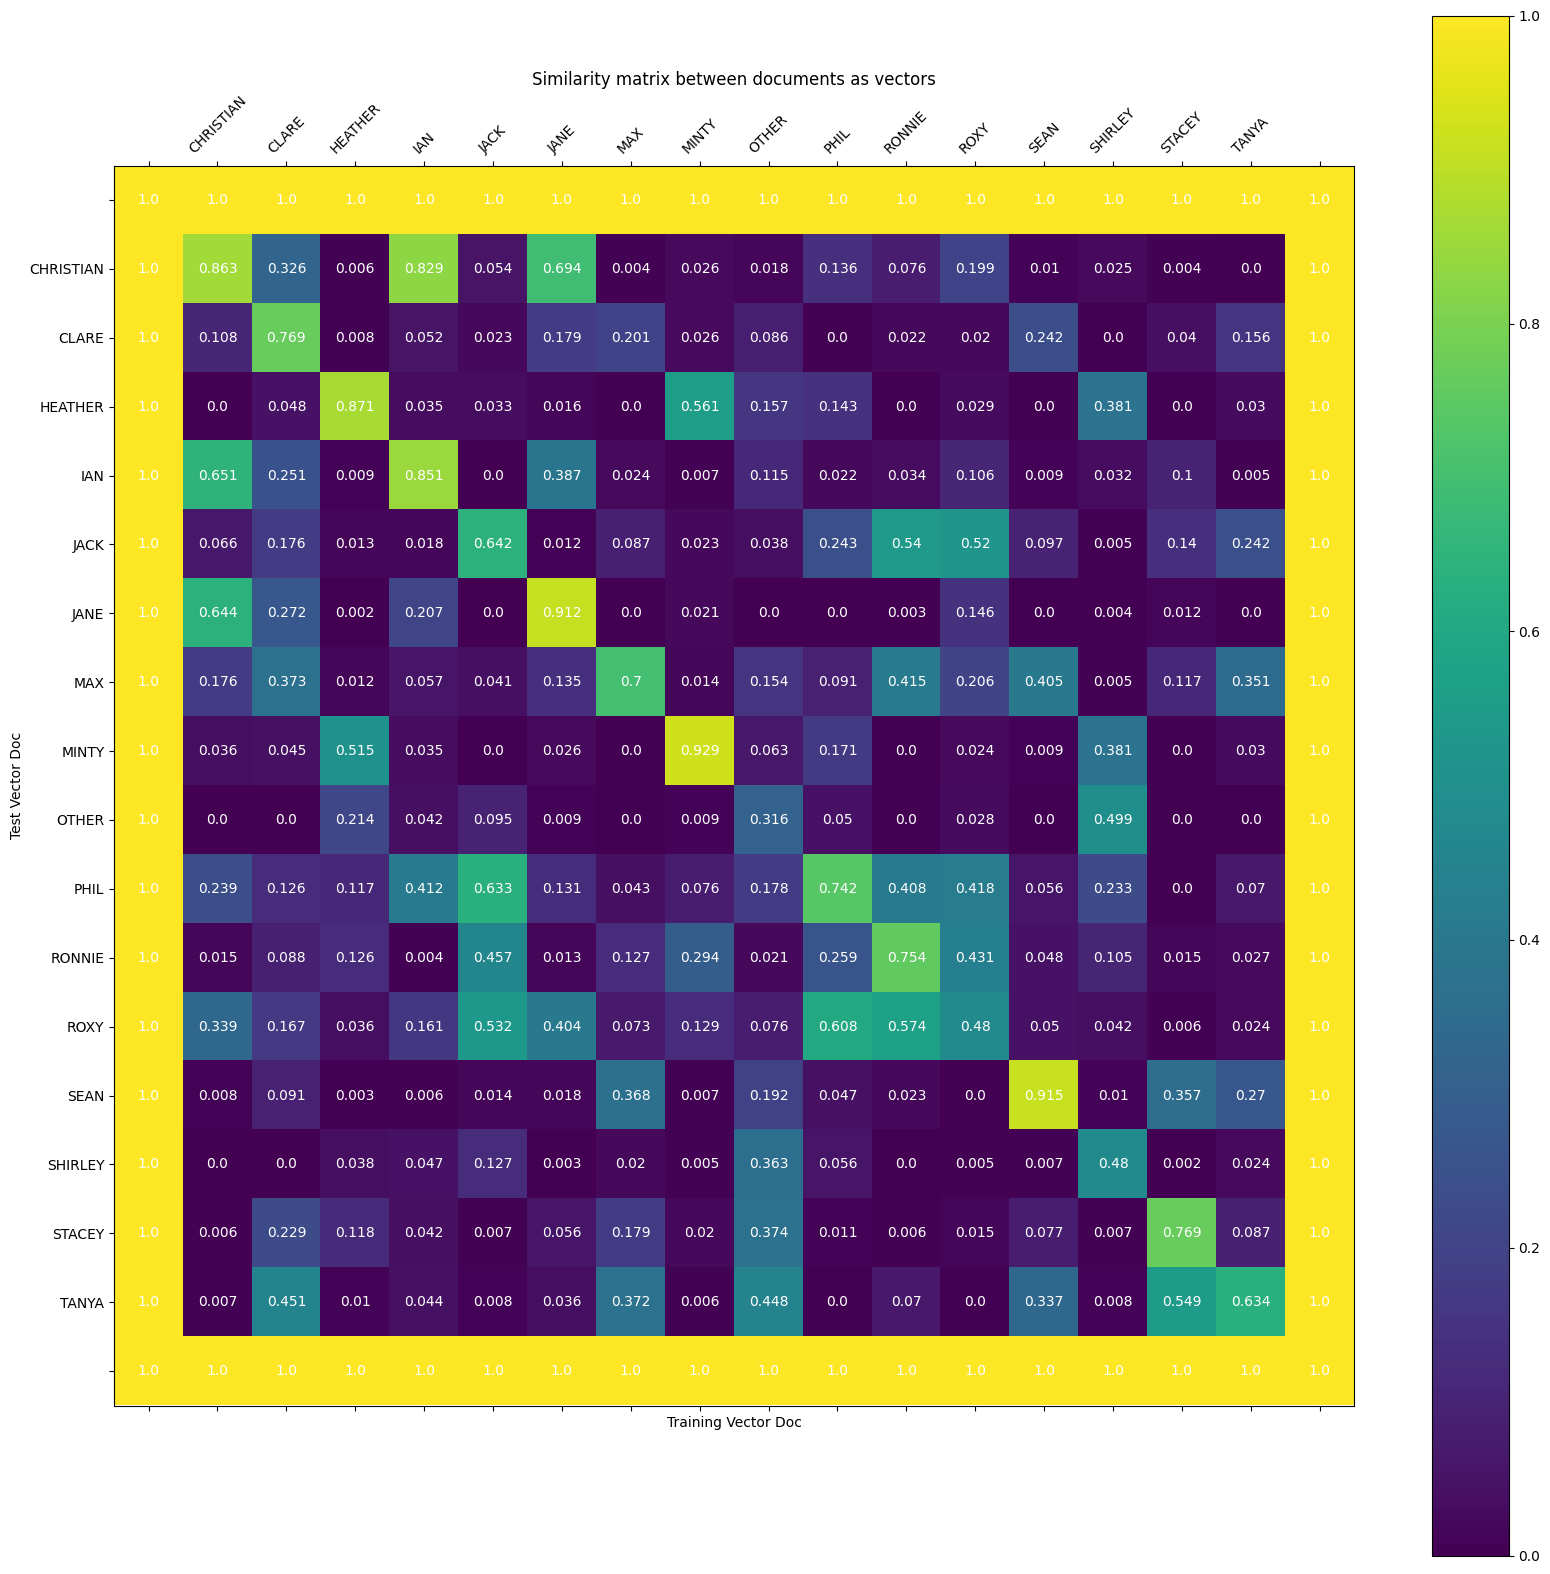

In [ ]:
plot_heat_map_similarity(df)